# Quick and Dirty attempt to train a model

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *

from pathlib import Path  ##great path for file paths

In [2]:
bs = 64
## bs = 16  ## for out of memory

In [3]:
data_fp = Path('./data/'); data_fp

PosixPath('data')

# Looking at the data

In [4]:
labels = pd.read_csv(data_fp.joinpath('train', 'train.csv'))
print(labels.shape)
labels.head()

(25361, 2)


,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [5]:
tfms = get_transforms(do_flip=False)

In [6]:
data = ImageDataBunch.from_csv(path=data_fp,
                               folder='train',
                               csv_labels='train/train.csv',
                               ds_tfms=tfms,  ## need this but dont know why
                               size=600,  ## because all the image size are different 
                               bs=bs)

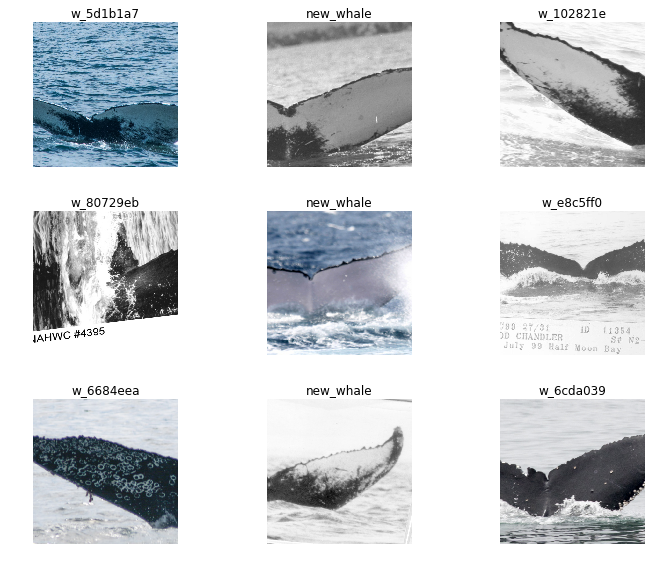

In [7]:
data.show_batch(rows=3, figsize=(10,8))